Covid 19 Detection


In [1]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import torch # this is the Pytorch pakcage
from torch.utils.data import Dataset as torch_dataset
from torch.utils.data import DataLoader as torch_dataloader
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch
import torch.nn as nn
import pandas as pd
from skimage.io import imread
import torch.nn.functional as nnF
import torch.optim as optim
from torch.utils.data import DataLoader as torch_dataloader
import torchvision
from torchvision import datasets, models, transforms
import torchvision.models as tv_models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as nnF
from collections import OrderedDict




In [2]:
Covid_Test = pd.read_csv("test.csv")
X_Test = Covid_Test['filename']
Y_Test = Covid_Test['label']
Covid_Train = pd.read_csv("train.csv")
X_Train = Covid_Train['filename']
Y_Train = Covid_Train['label']
Covid_Val = pd.read_csv("val.csv")
X_Val = Covid_Val['filename']
Y_Val = Covid_Val['label']

y_test = torch.from_numpy(Y_Test.values)
y_train = torch.from_numpy(Y_Train.values)
y_val = torch.from_numpy(Y_Val.values)


In [3]:
x_train = []
x_val = []
x_test = []
for n in range(0,X_Train.shape[0]):
  pic = imread(X_Train[n]).astype('float32')/255
  x_train.append(pic)
for n in range(0,X_Val.shape[0]):
  pic = imread(X_Val[n]).astype('float32')/255
  x_val.append(pic)
for n in range(0,X_Test.shape[0]):
  pic = imread(X_Test[n]).astype('float32')/255
  x_test.append(pic)

In [4]:
x_train = torch.FloatTensor(x_train)
x_val = torch.FloatTensor(x_val)
x_test = torch.FloatTensor(x_test)
x_train = x_train.reshape(2022,50176)
x_val = x_val.reshape(60,50176)
x_test = x_test.reshape(400,50176)
print("Train :",x_train.shape, y_train.shape)
print("Validation :", x_val.shape, y_val.shape)
print("Test :", x_test.shape, y_test.shape)

Train : torch.Size([2022, 50176]) torch.Size([2022])
Validation : torch.Size([60, 50176]) torch.Size([60])
Test : torch.Size([400, 50176]) torch.Size([400])


In [5]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):
        # self.X[idx] is numpy array, we need to convert it to torch tensor
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.Y[idx], dtype=torch.float32) #it needs to be float, not int
        return x, y

In [6]:
dataset_train = MyDataset(x_train, y_train)
dataset_val = MyDataset(x_val, y_val)
dataset_test = MyDataset(x_test, y_test)

In [7]:
#we must shuffle data points in the training set, set shuffle=True
dataloader_train = torch_dataloader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
dataloader_val = torch_dataloader(dataset_val, batch_size=64, shuffle=False, num_workers=0) 
dataloader_test = torch_dataloader(dataset_test, batch_size=64, shuffle=False, num_workers=0) 

In [8]:
for epoch in range(0, 1): # change 1 to 100 if we need to train the model for 100 epochs
    for batch_idx, (X, Y) in enumerate(dataloader_train):
        # X contain the data samples in a mini-batch
        # Y contain the class lables of these samples
        print(batch_idx, X.size(), Y.size())

0 torch.Size([64, 50176]) torch.Size([64])
1 torch.Size([64, 50176]) torch.Size([64])
2 torch.Size([64, 50176]) torch.Size([64])
3 torch.Size([64, 50176]) torch.Size([64])
4 torch.Size([64, 50176]) torch.Size([64])
5 torch.Size([64, 50176]) torch.Size([64])
6 torch.Size([64, 50176]) torch.Size([64])
7 torch.Size([64, 50176]) torch.Size([64])
8 torch.Size([64, 50176]) torch.Size([64])
9 torch.Size([64, 50176]) torch.Size([64])
10 torch.Size([64, 50176]) torch.Size([64])
11 torch.Size([64, 50176]) torch.Size([64])
12 torch.Size([64, 50176]) torch.Size([64])
13 torch.Size([64, 50176]) torch.Size([64])
14 torch.Size([64, 50176]) torch.Size([64])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


15 torch.Size([64, 50176]) torch.Size([64])
16 torch.Size([64, 50176]) torch.Size([64])
17 torch.Size([64, 50176]) torch.Size([64])
18 torch.Size([64, 50176]) torch.Size([64])
19 torch.Size([64, 50176]) torch.Size([64])
20 torch.Size([64, 50176]) torch.Size([64])
21 torch.Size([64, 50176]) torch.Size([64])
22 torch.Size([64, 50176]) torch.Size([64])
23 torch.Size([64, 50176]) torch.Size([64])
24 torch.Size([64, 50176]) torch.Size([64])
25 torch.Size([64, 50176]) torch.Size([64])
26 torch.Size([64, 50176]) torch.Size([64])
27 torch.Size([64, 50176]) torch.Size([64])
28 torch.Size([64, 50176]) torch.Size([64])
29 torch.Size([64, 50176]) torch.Size([64])
30 torch.Size([64, 50176]) torch.Size([64])
31 torch.Size([38, 50176]) torch.Size([38])


In [9]:

class Net(nn.Module):
    def __init__(self, input_dim, n_units):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units)
        self.layer2 = nn.Linear(n_units, n_units)
        self.layer3 = nn.Linear(n_units, 1)
    def forward(self, x):
        x=nnF.relu(self.layer1(x)) # same as x=self.layer1(x); x=nnF.relu(x)
        x=nnF.relu(self.layer2(x))
        z=self.layer3(x)
        # we need to do this
        z=z.view(-1) 
        #do not use sigmoid if we use binary_cross_entropy_with_logits loss in pytorch
        #z is called logits
        #y=nnF.sigmoid(z) 
        return z

In [10]:
model=Net(input_dim = 50176, n_units = 256)
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [11]:
def train(model, optimizer, dataloader, device, epoch):    
    model.train()#set model to train mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear the grad of each parameter
        Z = model(X) #forward pass
        loss = nnF.binary_cross_entropy_with_logits(Z, Y) #compute loss
        loss.backward() #backward pass
        optimizer.step() #update parameters
        loss_train+=loss.item() #record the loss
        #make prediction, do not need sigmoid
        Yp = (Z.data>0).to(torch.int64)    
        #measure accuracy on this batch
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * X.size(0), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset)
    return loss_train, acc_train

In [12]:
def test(model, dataloader, device):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0 
    with torch.no_grad(): # tell Pytorch not to build graph in this section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)    
            loss_test+=loss.item()
            #make prediction, do not need sigmoid
            Yp = (Z.data>0).to(torch.int64) 
            acc_test+= torch.sum(Yp==Y).item()
    loss_test/=len(dataloader)    
    acc_test/=len(dataloader.dataset)
    return loss_test, acc_test

In [13]:
def save_checkpoint(filename, model, optimizer, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
               filename)
    print('saved:', filename)

In [14]:
def load_checkpoint(filename, model, optimizer, device):
    checkpoint=torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [15]:
loss_train_list=[]
loss_val_list=[]
acc_train_list=[]
acc_val_list=[]

In [16]:
for epoch in range(0, 100):    
    #-------- perform training --------------------------------
    loss_train, acc_train =train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- perform validation --------------------------------
    loss_val, acc_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)
    #------ save model ------------------
    #you can choose to save model every 10 epochs
    #if epoch %10 == 0
    filename='NN_binary_classification_Pytorch_e'+str(epoch)+'.pt'
    save_checkpoint(filename, model, optimizer, epoch)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Train Epoch: 0 [0/2022 (0%)]	Loss: 0.703368
epoch 0 training loss: 0.6927148476243019 acc: 0.5435212660731948
epoch 0 validation loss: 0.7026283144950867 acc: 0.5
saved: NN_binary_classification_Pytorch_e0.pt
Train Epoch: 1 [0/2022 (0%)]	Loss: 0.661477
epoch 1 training loss: 0.6575110945850611 acc: 0.599406528189911
epoch 1 validation loss: 0.7269922494888306 acc: 0.5166666666666667
saved: NN_binary_classification_Pytorch_e1.pt
Train Epoch: 2 [0/2022 (0%)]	Loss: 0.662056
epoch 2 training loss: 0.5681233052164316 acc: 0.7126607319485658
epoch 2 validation loss: 0.6032405495643616 acc: 0.6666666666666666
saved: NN_binary_classification_Pytorch_e2.pt
Train Epoch: 3 [0/2022 (0%)]	Loss: 0.531278
epoch 3 training loss: 0.6039507230743766 acc: 0.6879327398615233
epoch 3 validation loss: 0.6051129698753357 acc: 0.65
saved: NN_binary_classification_Pytorch_e3.pt
Train Epoch: 4 [0/2022 (0%)]	Loss: 0.559134
epoch 4 training loss: 0.6168882278725505 acc: 0.6567754698318496
epoch 4 validation loss:

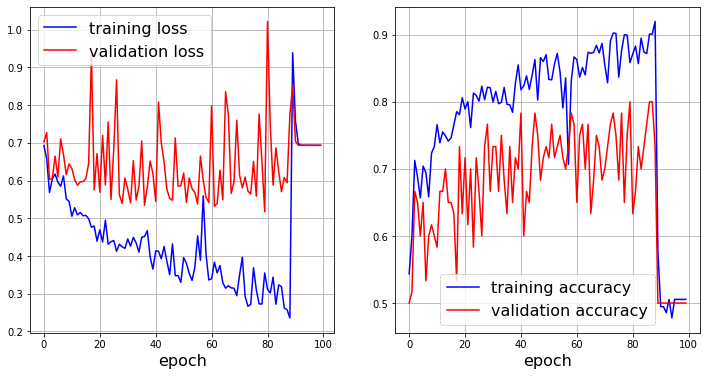

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-r', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

In [18]:
#to change the learning rate during traning, we may do this
for g in optimizer.param_groups:
    g['lr']=0.001

In [19]:
best_id= np.array(acc_val_list).argmax()
best_id

79

In [20]:
filename_best='NN_binary_classification_Pytorch_e' + str(best_id) + '.pt'
load_checkpoint(filename_best, model, optimizer, device)

In [21]:
loss_test, acc_test = test(model, dataloader_test, device)
print('test loss:', loss_test)
print('test accuracy', acc_test)

test loss: 0.4994007093565805
test accuracy 0.815


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
